In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress
import os

In [2]:
artemis_path = '../output-data/GSE-with-xpos/Artemis'
omni_path = '../output-data/GSE-with-xpos/Omni'

In [3]:
artemis_data = pd.read_csv('../output-data/GSE-with-xpos/Artemis/Artemis_2015-03-17_04-20.csv', delimiter=',', header=0, index_col=0)
omni_data = pd.read_csv('../output-data/GSE-with-xpos/Omni/Omni_2015-03-17_04-20.csv', delimiter=',', header=0, index_col=0)

In [4]:
start = 40
aStart = (artemis_data.loc[artemis_data['Time'] == omni_data['Time'][start]]).index[0]
aStop = (artemis_data.loc[artemis_data['Time'] == omni_data['Time'][start+59]]).index[0]

In [13]:
slope, intercept, rvalue, pvalue, stderr = linregress(omni_data['BZ_GSE'][start:(start+59)], artemis_data['BZ_GSE'][aStart-4:aStop-4])

In [14]:
x = np.arange(-50,50,1)
y = intercept + (slope*x)

In [16]:
print(omni_data['Time'][start])
print(artemis_data['Time'][aStart-4])

2015-03-17 05:30:00
2015-03-17 05:26:00


(-30.0, 30.0)

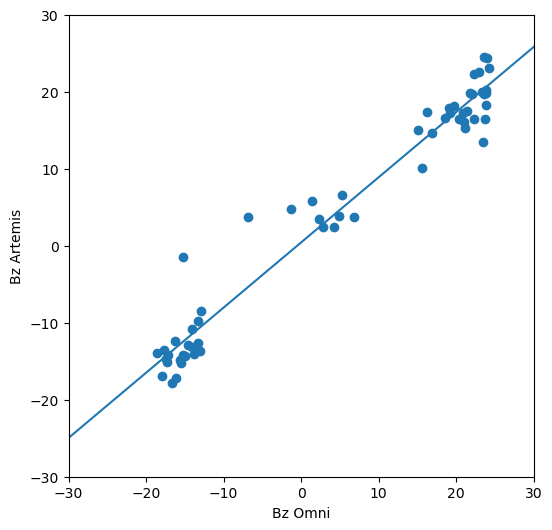

In [17]:
fig, ax = plt.subplots(figsize=(6,6))
plt.scatter(omni_data['BZ_GSE'][start:(start+59)], artemis_data['BZ_GSE'][aStart-4:aStop-4])
plt.plot(x,y)
plt.xlabel('Bz Omni')
plt.ylabel('Bz Artemis')

plt.xlim(-30,30)
plt.ylim(-30,30)

In [18]:
print(slope)

0.8459860782942145


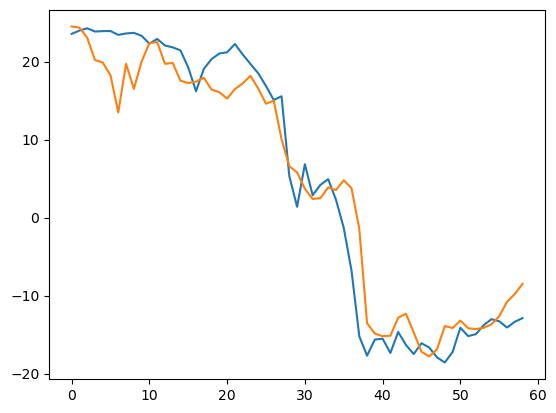

In [19]:
plt.plot([j for j in range(0,59)], omni_data['BZ_GSE'][start:(start+59)])
plt.plot([j for j in range(0,59)], artemis_data['BZ_GSE'][aStart-4:aStop-4])

plt.show()